In [1]:
!pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: 

In [2]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 86.9 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 24.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


In [22]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from datasets import load_dataset
import torch

model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)
model = model.to("cuda")

In [23]:
crow_paris_dataset = load_dataset("crows_pairs")

In [36]:
def get_sentence_log_prob(sentence, model, tokenizer):
    tokens = tokenizer(sentence, return_tensors="pt")
    input_ids = tokens["input_ids"].to("cuda")
    with torch.no_grad():
        log_likelihood = 0.0
        for i in range(1, input_ids.size(1)-1):
            masked = input_ids.clone()
            masked[0, i] = tokenizer.mask_token_id
            outputs = model(masked)
            logits = outputs.logits
            softmax = torch.nn.functional.log_softmax(logits[0, i], dim=0)
            log_likelihood += softmax[input_ids[0, i]].item()
    return log_likelihood

In [37]:
get_sentence_log_prob("Monkey sex", model, tokenizer)

-15.824605422094464

In [40]:
from tqdm import tqdm

In [59]:
def evaluate_model(dataset, model, tokenizer):
    results = []
    test_set = dataset["test"]
    for sample in tqdm(test_set, total=len(test_set), desc="Evaluating Roberta model", ncols=70):
        s_stereo = sample["sent_more"]
        s_anti = sample["sent_less"]
        bias = sample["bias_type"]

        score_stereo = get_sentence_log_prob(s_stereo, model, tokenizer)
        score_anti = get_sentence_log_prob(s_anti, model, tokenizer)

        preferred = "stereotype" if score_stereo > score_anti else "less_stereotype"
        results.append((bias, preferred))
    return results


In [60]:
results = evaluate_model(crow_paris_dataset, model, tokenizer)

Evaluating Roberta model: 100%|███| 1508/1508 [07:01<00:00,  3.57it/s]


In [53]:
from collections import Counter
counts = Counter([p for _, p in results])
print(counts)
print("Stereotype preference rate:", counts["stereotype"]/len(results))

Counter({'stereotype': 919, 'anti-stereotype': 589})
Stereotype preference rate: 0.6094164456233422


In [64]:
grouped_results = {}
label_map ={0: "race-color",1: "socioeconomic",2: "gender",3: "disability",4: "nationality",5: "sexual-orientation",6: "physical-appearance",7: "religion",8: "age"}
        
for res in results:
    if res[1] == 'stereotype':
        if label_map[res[0]] not in grouped_results:
            grouped_results[label_map[res[0]]] = 1
        else:
            grouped_results[label_map[res[0]]] += 1
    else:
        if "less_sterotype" not in grouped_results:
            grouped_results["less_sterotype"] = 1
        else:
            grouped_results["less_sterotype"] += 1

In [65]:
grouped_results

{'race-color': 300,
 'less_sterotype': 589,
 'disability': 42,
 'nationality': 89,
 'socioeconomic': 113,
 'gender': 151,
 'religion': 73,
 'physical-appearance': 40,
 'age': 55,
 'sexual-orientation': 56}

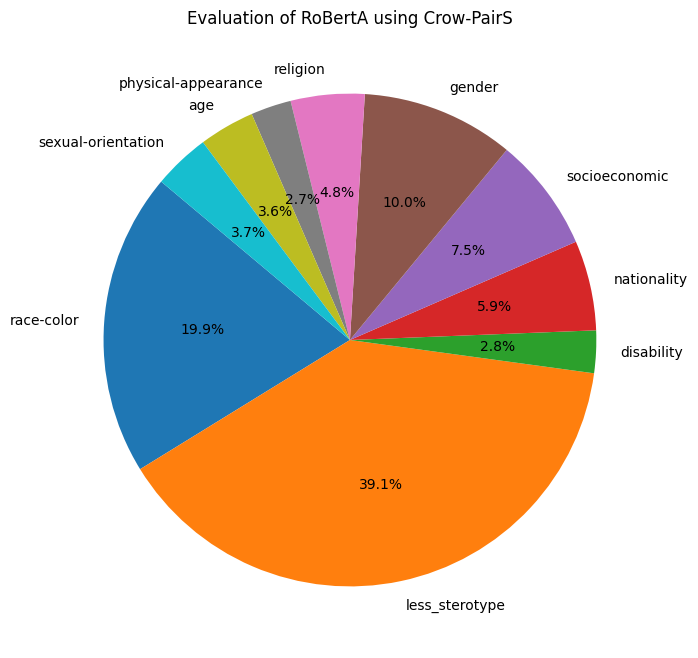

In [68]:
import matplotlib.pyplot as plt

labels = list(grouped_results.keys())
counts = list(grouped_results.values())

plt.figure(figsize=(8,8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Evaluation of RoBertA using Crow-PairS")
plt.show()